# Get and parse Spike sequences
This Python Jupyter notebook identifies the human Spike sequences and writes them to a file.

## Imports and configuration
Import modules and read configuration file:

In [1]:
import os
import re

import Bio.Entrez
import Bio.SeqIO

from IPython.display import display, HTML

import matplotlib.pyplot as plt

import pandas as pd

from plotnine import *

import yaml

Read configuration:

In [2]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

# create directories
for dirname in [config['results_dir'], config['genbank_seqs_dir']]:
    os.makedirs(dirname, exist_ok=True)

## Download sequences
Read the CSV giving the Genbank accessions for all sequences, identify just the ones that are human sequences, then download all of them:

Reading accessions and metadata from data/NCBI_Virus_229E_accessions.csv

Reading additional metadata from data/extra_229E_accessions_metadata.yaml

Reading accessions for exclusion from data/accessions_to_include_exclude_annotate.yaml
Read 2 accessions to exclude.

Retaining just the 327 of 544 accessions that are human.
There are 327 accessions in data/NCBI_Virus_229E_accessions.csv, of which 0 are not already downloaded in results/genbank_seqs.


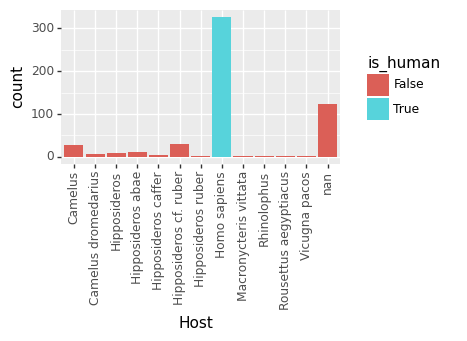

In [3]:
# read the accession data frame
print(f"Reading accessions and metadata from {config['accessions']}\n")
acc_df = pd.read_csv(config['accessions'])
assert acc_df['Accession'].nunique() == len(acc_df)

# add additional manually specified metadata
print(f"Reading additional metadata from {config['addtl_accessions_metadata']}")
with open(config['addtl_accessions_metadata']) as f:
    addtl_metadata = (
            pd.DataFrame.from_dict(yaml.safe_load(f), orient='index')
            .rename_axis('Accession')
            .reset_index()
            )
assert set(addtl_metadata.columns).issubset(acc_df.columns)
assert set(addtl_metadata['Accession']).issubset(acc_df['Accession'])
# make sure additional metadata is only replacing NA values
replace_df = acc_df[addtl_metadata.columns].merge(addtl_metadata, on='Accession')
assert all(all(1 == replace_df[f"{col}_x"].isnull().astype(int) + replace_df[f"{col}_y"].isnull().astype(int))
           for col in addtl_metadata.columns if col != 'Accession')
# fill in additional metadata
addtl_acc = addtl_metadata['Accession'].tolist()
acc_df = (acc_df
          .set_index('Accession')
          .combine_first(addtl_metadata.set_index('Accession'))
          .reset_index()
          )

# additional metadata that may specify accessions for exclusion
print(f"\nReading accessions for exclusion from {config['accessions_special']}")
with open(config['accessions_special']) as f:
    acc_exclude = yaml.safe_load(f)['exclude']
print(f"Read {len(acc_exclude)} accessions to exclude.")
acc_df = acc_df.query('Accession not in @acc_exclude')

# identify and retain human sequences:
acc_df = acc_df.assign(is_human=lambda x: x['Host'] == 'Homo sapiens')
p = (ggplot(acc_df) +
     aes('Host', fill='is_human') +
     geom_bar() +
     theme(axis_text_x=element_text(angle=90),
           figure_size=(0.3 * acc_df['Host'].nunique(), 2))
     )
_ = p.draw()
print(f"\nRetaining just the {len(acc_df.query('is_human == True'))} of {len(acc_df)} accessions that are human.")
acc_df = acc_df.query('is_human == True')

acc_to_file = {acc: os.path.join(config['genbank_seqs_dir'], f"{acc}.gb")
               for acc in acc_df['Accession']}
missing_accessions = {acc: f for acc, f in acc_to_file.items() if not os.path.isfile(f)}
print(f"There are {len(acc_to_file)} accessions in {config['accessions']}, of which "
      f"{len(missing_accessions)} are not already downloaded in {config['genbank_seqs_dir']}.")
if config['redownload_genbank']:
    to_download = acc_to_file
    print(f"Downloading all {len(to_download)} accessions (overwriting any existing ones).")
else:
    to_download = missing_accessions
    print(f"Downloading the {len(to_download)} accessions not already in {config['genbank_seqs_dir']}.")

Bio.Entrez.email = config['email']  # set e-mail address for downloads    
update_every = 25
for i, (acc, fname) in enumerate(to_download.items()):
    if i % update_every == 0:
        print(f"Progress: accession {i + 1} of {len(to_download)}")
    gb_text = Bio.Entrez.efetch(db='nucleotide',
                                id=acc,
                                rettype='gb',
                                retmode='text',
                                ).read()
    with open(fname, 'w') as f:
        f.write(gb_text)

## Parse Spike coding sequences
Make a data frame that has a row for each CDS in each Genbank accession (these accessions often represent many CDSs), identify what products these CDSs correspond to, and extract the CDS sequence.
Furthermore, use the CDS product name to determine if it is Spike.
After doing this, we plot the number of CDSs for each product name, colored by whether they are Spike.
Look at this plot to make sure that everything colored as Spike indeed appears to be Spike, and everything **not** colored as Spike is not Spike:

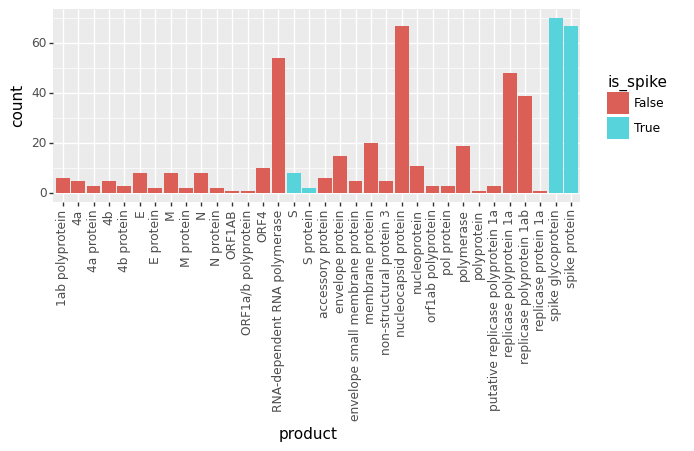

In [4]:
cds_df = (
    acc_df
    .assign(SeqRecord=lambda x: (x['Accession']
                                 .map(acc_to_file)
                                 .apply(Bio.SeqIO.read, format='gb')
                                 ),
            cds_features=lambda x: x['SeqRecord'].map(lambda s: [f for f in s.features if f.type == 'CDS']),
            n_cds_features=lambda x: x['cds_features'].map(len)
            )
    .query('n_cds_features > 0')
    .explode('cds_features')
    .rename(columns={'cds_features': 'cds_feature'})
    .assign(product=lambda x: x['cds_feature'].map(lambda f: f.qualifiers['product'][0]),
            sequence=lambda x: x.apply(lambda r: r['cds_feature'].extract(r['SeqRecord']).seq,
                                       axis=1),
            sequence_length=lambda x: x['sequence'].map(len),
            is_spike=lambda x: x['product'].str.match('^(S|s)'),
            )
    )

p = (ggplot(cds_df) +
     aes('product', fill='is_spike') +
     geom_bar() +
     theme(axis_text_x=element_text(angle=90),
           figure_size=(0.2 * cds_df['product'].nunique(), 2.5))
     )
_ = p.draw()

Now get a data frame that is just Spike, getting protein and nucleotide sequences without any terminal stop codons, 
filtering just to those of valid lengths, and checking for problematic features like premature stop codons or ambiguous nucleotides:

Here is plot of number of Spikes at each protein length; only keeping those with valid length:


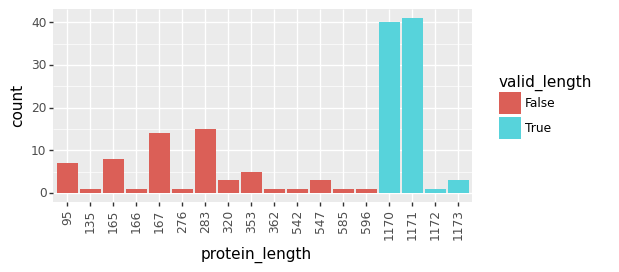


Removing 0 of 85 Spikes for failing premature_stop filter.

Removing 2 of 85 Spikes for failing ambiguous_nts filter.
Here are the sequences being filtered:


Accession,Authors,Geo_Location,country,collection_date,GenBank_Title,sequence,protein
JX503060,"Farsani,S.M., Dijkman,R., Jebbink,M.F., Goossens,H., Ieven,M., Deijs,M., Molenkamp,R., van der Hoek,L.",Netherlands,Netherlands,2010-01-01,"Human coronavirus 229E isolate 0349, complete genome",ATGTTTGTTTTACTTGTTGCATATGCCTTGTTGCATATTGCTGGTTGTCAAACTACAAATGGGACGAACACTAGTCACTCTGTTTGCAACGGCTGTGTTGGTCATTCGGAAAATGTATTTGCTGTTGAGAGTGGTGGTTATATACCCTCCAACTTTGCATTTAATAATTGGTTCCTCTTAACTAATACCTCATCTGTTGTAGATGGTGTTGTGAGGAGTTTTCAGCCTTTGTTGCTTAATTGCTTATGGTCTGTTTCTGGCTCGCGGTTTACTACTGGTTTTGTCTATTTTAATGGTACTGGGAGAGGTGATTGTAAAGGTTTTTATTCAAATGCTTCGTCTGATGTCATACGTTACAACATCAATTTTGAAGAAAACCTTAGACGTGGAACCATTTTGTTTAAAACATCTTATGGTGCTGTTGTGTTTTATTGTACCAACAACACTTTGGTTTCAGGTGATGCTCACATACCATCTGGTACAGTTTTGGGCAATTTTTATTGCTTTGTAAATACTACTATTGACAATGAAACTACGTCTGCTTTTGTGGGTGCACTACCTAAGACAGTTCGTGAGTTTGTTATTTCACGCACAGGACATTTTTATATTAATGGCTATCGCTATTTCTCTTTAGGTAATGTAGAAGCCGTTAATTTCAATGTCACTAACGCTGCAACCACTGTTTGTACTGTTGCGTTAGCTTCTTATGCTGACGTTTTGGTTAATGTGTCACAAACTGCTATTGCTAATATAATTTATTGCAATTCTGTTATTAACAGACTGAGATGTGACCAGTTGTCCTTTGATGTACCAGATGGCTTTTATTCCACAAGCCCTATTCAATCCGTTGAGCTACCTGTGTCTATTGTGTCGTTACCTGTTTATCACAAACACACGTTTATTGTGTTGTATGTCAACTTCGAACTTCGGCGTGGCCCTGGCAGGTGCTATAACTGTCGTCCTGCTGTTGTTAATATTACACTGGCCAATTTTAATGAAACTAAAGGGCCCTTGTGTGTTGACACATCACACTTCACTACCCAATTCGTTGGTAATGTCAAGCTTGATAGGTGGAGTGCTAGTATTAACACGGGAAATTGCCCTTTTTCTTTTGGCAAAGTTAATAACTTTGTTAAATTTGGCAGTGTATGTTTTTCGCTAAAGGATATACCCGGTGGTTGCGCAATGCCTATAATGGCTAATTTGGTTAATCATAAATCTCATAATATAGGCTCATTGTATGTTTCTTGGAGTGATGGTGATGTAATTACTGGCGTCCCGAAACCTGTTGAGGGTGTTAGTTCCTTTATGAATGTTACATTGAATAAATGTACTAAATATAACATTTATGATGTATCTGGTGTGGGTGTTATTCGTATTAGCAATGACACCTTTCTTAATGGAATTACGTACACATCAACTTCAGGTAACCTTCTGGGTTTTAAAGATGTTACTAATGGCACCATCTACTCTATCACTCCTTGTAACCCACCAGATCAGCTTGTTGTTTATCAGCAAGCTGTTGTTGGTGCTATGTTGTCTGAAAACTTTACTAGTTACGGCTTTTCTAATGTTGTAGAAATGCCGAAATTTTTCTATGCGTCCAATGGCACTTATAATTGCACAGACGCTGTTTTAACTTATTCTAGTTTTGGCGTTTGTGCAGATGGTTCTATAATTGCTGTTCAACCACGTAATGTTTCATATGATAGTGTTTCAGCTATTGTCACAGCTAATTTGTCTATACCCTCCAATTGGACCACTTCGGTCCAGGTTGAGTATTTACAAATTACAAGTACACCTATCRTAGTTGATTGCTCCACTTATGTTTGCAATGGTAATGTGCGCTGTGTTGAATTGCTTAAGCAGTATACTTCTGCTTGTAAAACTATTGAAGACGCCTTAAGAAATAGCGCCATGCTGGAGTCTGCAGATGTTAGTGAGATGCTCACTTTTGACAAGAAAGCGTTTACACTTGCTAATGTTAGTAGTTTTGGTGACTACAACCTTAGCAGTGTTATACCTAGCTTGCCCAGAAGTGGTAGTAGAGTGGCTGGTCGCAGTGCCATAGAAGACATACTTTTTAGCAAACTTGTTACGTCTGGACTTGGCACTGTGGACGCAGACTACAAAAAGTGTACTAAGGGTCTTTCCATTGCTGACTTGGCTTGTGCCCAATATTATAATGGCATTATGGTTTTGCCTGGCGTCGCTGATGCTGAACGTATGGCCATGTATACAGGTTCTTTAATTGGTGGAATTGCTTTAGGAGGTCTTACATCAGCCGCTTCAATACCATTTTCATTAGCAATTCAGTCACGTTTAAATTATGTTGCATTGCAGACTGATGTTTTACAAGAAAATCAGAAAATTCTTGCTGCATCTTTTAATAAAGCAATGACCAACATAGTAGATGCCTTTACTGGTGTTAATGATGCTATTACACAAACTTCACAAGCTCTACAAACAGTTGCTACTGCACTTAATAAGATCCAGGATGTTGTTAATCAACAAGGCAACTCATTGAACCATTTAACTTCTCAGTTGAGGCAGAATTTTCAAGCCATTTCTAGCTCTATTCAGGCTATCTATGACAGACTTGATATTATTCAGGCTGATCAACAAGTAGATAGGCTGATTACTGGTAGATTGGCTGCTCTGAATGTATTCGTTTCTCATACATTGACTAAGTACACTGAAGTTCGTGCTTCCAGACAGCTTGCACAACAAAAAGTGAATGAGTGTGTCAAATCCCAGTCTAAGCGGTATGGCTTCTGTGGAAATGGCACGCACATTTTCTCACTTGTTAATGCTGCTCCTGAGGGGCTTGTTTTTCTCCATACTGTCTTGTTGCCGACACAATATAAGGATGTTGAAGCGTGGTCTGGGTTGTGCGTTGATGGTATAAACGGTTATGTGTTGAGACAACCTAATCTTGCTCTTTACAAAGAAGGCAATTATTATAGAATTACATCTCGCATAATGTTTGAACCACGTATTCCTACCATAGCAGATTTTGTCCAAATTGAAAATTGCAATGTCACATTTGTTAACATTTCTCGCTCTGAGTTGCAAACTATTGTGCCAGAGTATATTGATGTTAATAAGACGCTGCAAGAATTAAGTTACAAATTGCCAAATTACACTGTTCCAGACCTAGTTGTCGAACAGTACAACCAGACTATTTTGAATTTGACCAGTGAAATTAGCACCCTTGAAAATAAATCTGCGGAGCTTAATTACACTGTTCAAAAACTGCAAACTTTGATCGACAACATAAATAGCACATTAGTTGACTTAAAGTGGCTCAACCGTGTTGAGACTTATATCAAGTGGCCTTGGTGGGTGTGGTTGTGCATTTCAGTCGTGCTCATCTTTGTGGTGAGTATGTTGCTATTATGTTGTTGTTCTACTGGTTGCTGCGGCTTCTTTAGTTGTTTTGCATCTTCTATTAGAGGTTGTTGTGAATCAACTAAACTTCCTTATTACGACGTTGAAAAGATCCACATACAG,MFVLLVAYALLHIAGCQTTNGTNTSHSVCNGCVGHSENVFAVESGGYIPSNFAFNNWFLLTNTSSVVDGVVRSFQPLLLNCLWSVSGSRFTTGFVYFNGTGRGDCKGFYSNASSDVIRYNINFEENLRRGTILFKTSYGAVVFYCTNNTLVSGDAHIPSGTVLGNFYCFVNTTIDNETTSAFVGALPKTVREFVIS


Removing 3 of 83 Spikes for failing no_collection_date filter.
Here are the sequences being filtered:


Accession,Authors,Geo_Location,country,collection_date,GenBank_Title,sequence,protein
KF293664,"Lundin,A., Dijkman,R., Bergstrom,T., Kann,N., Adamiak,B., Hannoun,C., Kindler,E., Jonsdottir,H., Muth,D., Muller,M., Drosten,C., Thiel,V., Trybala,E.",Sweden,Sweden,NaT,"Human coronavirus 229E clone p0, partial genome",ATGTTTGTTTTGCTTGTTGCATATGCCTTGTTGCATATTGCTGGTTGTCAAACTACAAATGGGCTGAACACTAGTTACTCTGTTTGCAACGGCTGTGTTGGTTATTCAGAAAATGTATTTGCTGTTGAGAGTGGTGGTTATATACCCTCCGACTTTGCATTCAATAATTGGTTCCTTCTAACTAATACCTCATCTGTTGTAGATGGTGTTGTGAGGAGTTTTCAGCCTTTGTTGCTTAATTGCTTATGGTCTGTTTCTGGCTTGCGGTTTACTACTGGTTTTGTCTATTTTAATGGTACTGGGAGAGGTGATTGTAAAGGTTTTTCCTCAGATGTTTTGTCTGATGTCATACGTTACAACCTCAATTTTGAAGAAAACCTTAGACGTGGAACCATTTTGTTTAAAACATCTTATGGTGTTGTTGTGTTTTATTGTACCAACAACACTTTAGTTTCAGGTGATGCTCACATACCATTTGGTACAGTTTTGGGCAATTTTTATTGCTTTGTAAATACTACTATTGGCAATGAAACTACGTCTGCTTTTGTGGGTGCACTACCTAAGACAGTTCGTGAGTTTGTTATTTCACGCACAGGACATTTTTATATTAATGGCTATCGCTATTTCACTTTAGGTAATGTAGAAGCCGTTAATTTCAATGTCACTACTGCAGAAACCACTGATTTTTTTACTGTTGCGTTAGCTTCTTATGCTGACGTTTTGGTTAATGTGTCACAAACCTCTATTGCTAATATAATTTATTGCAACTCTGTTATTAACAGACTGAGATGTGACCAGTTGTCCTTTGATGTACCAGATGGTTTTTATTCTACAAGCCCTATTCAATCCGTTGAGCTACCTGTGTCTATTGTGTCGCTACCTGTTTATCATAAACATACGTTTATTGTGTTGTACGTTGACTTCAAACCTCAGAGTGGCGGTGGCAAGTGCTTTAACTGTTATCCTGCTGGTGTTAATATTACACTGGCCAATTTTAATGAAACTAAAGGGCCTTTGTGTGTTGACACATCACACTTCACTACCAAATACGTTGCTGTTTATGCCAATGTTGGTAGGTGGAGTGCTAGTATTAACACGGGAAATTGCCCTTTTTCTTTTGGCAAAGTTAATAACTTTGTTAAATTTGGCAGTGTATGTTTTTCGCTAAAGGATATACCCGGTGGTTGCGCAATGCCTATAGTGGCTAATTGGGCTTATAGTAAGTACTATACTATAGGCTCATTGTATGTTTCTTGGAGTGATGGTGATGGAATTACTGGCGTCCCACAACCTGTTGAGGGTGTTAGTTCCTTTATGAATGTTACATTGGACAAATGTACTAAATATAATATTTATGATGTATCTGGTGTGGGTGTTATTCGCGTTAGCAATGACACCTTTCTTAATGGAATTACGTACACATCAACTTCAGGTAACCTTCTGGGTTTTAAAGATGTTACTAAGGGCACCATCTACTCTATCACTCCTTGTAACCCACCAGATCAGCTTGTTGTTTATCAGCAAGCTGTTGTTGGTGCTATGTTGTCTGAAAATTTTACTAGTTACGGCTTTTCTAATGTTGTAGAACTGCCGAAATTTTTCTATGCGTCCAATGGCACTTATAATTGCACAGACGCTGTTTTAACTTATTCTAGTTTTGGCGTTTGTGCAGATGGTTCTATAATTGCTGTTCAACCACGTAATGTTTCATATGATAGTGTTTCAGCTATCGTCACAGCTAATTTGTCTATACCTTCCAATTGGACCACTTCGGTCCAGGTTGAGTATTTACAAATTACAAGTACACCTATCGTAGTTGATTGCTCCACTTATGTTTGCAATGGTAATGTGCGCTGTGTTGAATTGCTTAAGCAGTATACTTCTGCTTGTAAAACTATCGAAGACGCCTTAAGAAATAGCGCCAGGCTGGAGTCTGCAGATGTTAGTGAGATGCTCACTTTTGACAAGAAAGCGTTTACACTTGCTAATGTTAGTAGTTTTGGTGACTACAACCTTAGCAGCGTCATACCTAGCTTGCCCACAAGTGGTAGTAGAGTGGCTGGTCGCAGTGCCATAGAAGACATACTTTTTAGCAAAATTGTTACTTCTGGACTTGGCACTGTGGACGCAGACTACAAAAATTGCACTAAGGGTCTTTCCATTGCTGACTTGGCTTGTGCTCAATATTATAATGGCATTATGGTTTTGCCTGGCGTCGCTGATGCTGAACGAATGGCCATGTATACAGGTTCTTTAATTGGTGGAATTGCTTTAGGAGGTCTAACATCAGCCGTTTCAATACCATTTTCATTAGCAATTCAGGCACGTTTAAATTATGTTGCATTGCAGACTGATGTTTTACAAGAAAATCAGAAAATTCTTGCTGCATCTTTTAACAAAGCAATGACCAACATAGTAGATGCCTTTACTGGTGTTAATGATGCTATTACACAAACTTCACAAGCCCTACAAACAGTTGCTACTGCACTTAACAAGATCCAGGATGTTGTTAATCAACAAGGCAACTTATTGAACCATTTAACTTCTCAGTTGAGGCAGAATTTTCAAGCTATCTCTAGCTCTATTCAGGCTATCTATGACAGACTTGACACTATTCAGGCTGATCAACAAGTAGATAGGCTGATTACTGGTAGATTGGCTGCTTTGAATGTATTCGTTTCTCATACATTGACTAAGTACACTGAAGTTCGTGCTTCCAGACAGCTTGCACAACAAAAAGTGAATGAGTGTGTCAAATCCCAGTCTAAGCGTTATGGCTTCTGTGGAAATGGCACTCACATTTTCTCAATTGTTAATGCTGCTCCTGAGGGGCTTGTTTTTTTCCACACTGTCTTGTTGCCGACACAATATAAGGATGTTGAAGCGTGGTCTGGGTTGTGCGTTGATGGTACAAACGGTTATGTGTTGCGACAACCTAATCTTGCTCTTTACAAAGAAGGCAATTATTATAGAATCACATCTCGCATAATGTTTGAACCACGTATTCCTACCATGGCAGATTTTGTTCAAATTGAAAATTGCAATGTCACATTTGTTAACATTTCTCGCTCTGAGTTGCAAACCATTGTGCCAGAGTATATTGATGTTAATAAGACGCTGCAAGAATTAAGTTACAAATTGCCAAATTACACTGTTCCAGACCTAGTTGTCGAACAGTACAACCAGACTATTTTGAATTTGACCAGTGAAATTAGCACCCTTGAAAATAAATCTGCGGAGCTTAATTACACTGTTCAAAAATTGCAAACTCTGATTGACAACATAAATAGCACATTAGTCGACTTAAAGTGGCTCAACCGGGTTGAGACTTACATCAAGTGGCCGTGGTGGGTGTGGTTGTGCATTTCAGTCGTGCTCATCTTTGTGGTGAGTATGTTGCTATTATGTTGTTGTTCTACTGGTTGCTGTGGCTTCTTTAGTTGTTTTGCATCTTCTATTAGAGGTTGTTGTGAATCAACTAAACTTCCTTATTACGACGTTGAAAAGATCCACATACAG,MFVLLVAYALLHIAGCQTTNGLNTSYSVCNGCVGYSENVFAVESGGYIPSDFAFNNWFLLTNTSSVVDGVVRSFQPLLLNCLWSVSGLRFTTGFVYFNGTGRGDCKGFSSDVLSDVIRYNLNFEENLRRGTILFKTSYGVVVFYCTNNTLVSGDAHIPFGTVLGN


Overall, retained 80 Spikes.


In [5]:
spike_df = (
    cds_df
    .query('is_spike == True')
    .assign(seq_multiple_3=lambda x: x['sequence'].map(lambda s: s[: (len(s) // 3) * 3]),
            prot_with_stop=lambda x: x['seq_multiple_3'].map(lambda x: x.translate()).map(str),
            has_terminal_stop=lambda x: x['prot_with_stop'].str[-1] == '*',
            protein=lambda x: x.apply(lambda r: r['prot_with_stop'][: len(r['prot_with_stop']) -
                                                                       int(r['has_terminal_stop'])],
                                      axis=1),
            sequence=lambda x: x.apply(lambda r: r['seq_multiple_3'][: len(r['seq_multiple_3']) -
                                                                        3 * int(r['has_terminal_stop'])],
                                       axis=1).map(str),
            protein_length=lambda x: x['protein'].map(len),
            valid_length=lambda x: x['protein_length'].map(lambda n: config['prot_length_range'][0] <= n
                                                                     <= config['prot_length_range'][1]),
            premature_stop=lambda x: x['protein'].str.contains('*', regex=False),
            ambiguous_nts=lambda x: x['sequence'].str.contains('[^ACGT]'),
            country=lambda x: x['Geo_Location'].str.split(':').map(lambda y: y[0]),
            collection_date=lambda x: pd.to_datetime(x['Collection_Date']),
            no_collection_date=lambda x: x['collection_date'].isnull(),
            )
    )

print('Here is plot of number of Spikes at each protein length; only keeping those with valid length:')
p = (ggplot(spike_df.assign(protein_length=lambda x: pd.Categorical(x['protein_length']))) +
     aes('protein_length', fill='valid_length') +
     geom_bar() +
     theme(axis_text_x=element_text(angle=90),
           figure_size=(0.3 * spike_df['protein_length'].nunique(), 2.5),
           )
     ).draw()
display(p)
plt.close(p)

spike_df = spike_df.query('valid_length')

# columns we keep to print
cols_of_interest = ['Accession', 'Authors', 'Geo_Location', 'country',
                    'collection_date', 'GenBank_Title', 'sequence', 'protein']

for filter_criteria in ['premature_stop', 'ambiguous_nts', 'no_collection_date']:
    df_fail = spike_df.query(filter_criteria)
    print(f"\nRemoving {len(df_fail)} of {len(spike_df)} Spikes for failing {filter_criteria} filter.")
    if len(df_fail):
        print('Here are the sequences being filtered:')
        display(HTML(df_fail[cols_of_interest].to_html(index=False)))
        spike_df = spike_df.query(f"not {filter_criteria}")
        
# add strain names
def get_strain_name(genbank_title):
    """Parse meaningful strain name from `GenBank_Title`"""
    m = re.match('Human coronavirus 229E (?:isolate|strain|S gene for spike protein, complete cds, isolate\:) '
                 '(?:HCoV_229E/|HCoV\-229E/|229E/human/|229E/)?'
                 '([^\s,]+)'
                 '(?: spike|, |$)',
                 genbank_title)
    if m is None:
        raise ValueError(f"cannot match GenBank_Title:\n{genbank_title}")
    return m.group(1)

# add nice names and sort by date, and get columns of interest
cols_of_interest = ['name', 'date', 'year'] + cols_of_interest
spike_df = (
    spike_df
    .assign(name=lambda x: x['GenBank_Title'].map(get_strain_name),
            year=lambda x: x['collection_date'].dt.year,
            # decimal year as here: https://stackoverflow.com/a/49021293
            date=lambda x: x['collection_date'].dt.year +
                           (x['collection_date'].dt.dayofyear - 1) / 365,
            )
    .sort_values('collection_date')
    .reset_index()
    [cols_of_interest]
    )
assert len(spike_df) == spike_df['name'].nunique()

print(f"\nOverall, retained {len(spike_df)} Spikes.")

## Examine distribution of sequences by year and country
Plot Spike sequence isolation year and location (country):

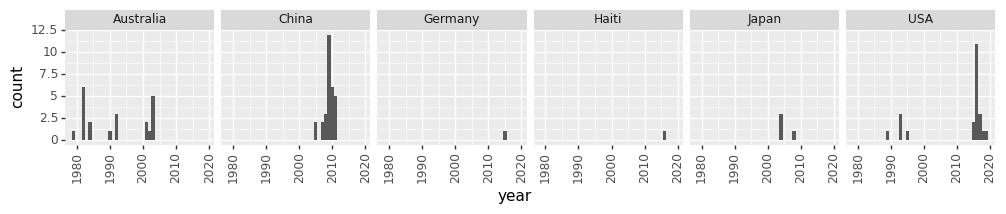

In [6]:
p = (ggplot(spike_df) +
     aes('year') +
     geom_histogram(binwidth=1) +
     facet_wrap('~ country', nrow=1) +
     theme(axis_text_x=element_text(angle=90),
           figure_size=(2 * spike_df['country'].nunique(), 1.5),
           )
     )

_ = p.draw()

## Collapse identical proteins
If specified in the configuration, we get just the Spikes that have unique protein sequences.
When choosing which one to retain, we choose as follows:
 - Keep it if it's specifically specified for retention.
 - Otherwise keep the first by date, and then by name (alphabetical)

In [7]:
if config['remove_redundant_prot']:
    print(f"Processing the {len(spike_df)} Spikes to only keep unique protein sequences.")
    
    # additional metadata that may specify accessions for inclusion
    print(f"\nReading accessions for inclusion from {config['accessions_special']}")
    with open(config['accessions_special']) as f:
        acc_include = yaml.safe_load(f)['include']
    if acc_include:
        print('The following accessions are specified for inclusion:\n\t' + '\n\t'.join(acc_include))
    assert len(spike_df) == spike_df['name'].nunique()
    unique_spike_df = (
        spike_df
        .assign(include=lambda x: x['Accession'].isin(acc_include),
                n_redundant_seqs=lambda x: x.groupby('protein')['name'].transform('count'),
                )
        .sort_values(['include', 'date', 'name'], ascending=[False, True, True])
        .groupby('protein')
        .first()
        .reset_index()
        .sort_values('date')
        .drop(columns='include')
        )
    print(f"\nRetained {len(unique_spike_df)} Spikes with unique protein sequences.")

else:
    unique_spike_df = spike_df

Processing the 80 Spikes to only keep unique protein sequences.

Reading accessions for inclusion from data/accessions_to_include_exclude_annotate.yaml
The following accessions are specified for inclusion:
	DQ243972
	DQ243976
	DQ243977
	KM055556
	KY369909

Retained 57 Spikes with unique protein sequences.


## Write Spike sequences and metadata to files
Write the **unaligned** Spike nucleotide and protein sequences to a FASTA file with the strain names as headers, and write the metadata for each strain to a CSV file:

In [8]:
print(f"Writing Spike nucleotide sequences to {config['spikes_unaligned_nt']}, protein "
      f"sequences to {config['spikes_unaligned_prot']} and metadata to {config['spikes_metadata']}")

(unique_spike_df
 .drop(columns=['sequence', 'protein'])
 .to_csv(config['spikes_metadata'], index=False)
 )

for fname, attr in [(config['spikes_unaligned_nt'], 'sequence'),
                    (config['spikes_unaligned_prot'], 'protein')]:
    with open(fname, 'w') as f:
        for row in unique_spike_df.itertuples():
            f.write(f">{row.name}\n{getattr(row, attr)}\n")

Writing Spike nucleotide sequences to results/spikes_unaligned_nt.fasta, protein sequences to results/spikes_unaligned_prot.fasta and metadata to results/spikes_metadata.csv


In [9]:
unique_spike_df.query('year == 2016')

,protein,name,date,year,Accession,Authors,Geo_Location,country,collection_date,GenBank_Title,sequence,n_redundant_seqs
51,MFVLLVAYALLHIAGCQTTNGTNTSHSVCNGCVGHSENVFDVESGG...,Seattle/USA/SC2282/2017,2016.000000,2016,KY684760,"Greninger,A.L., Makhsous,N., Kuypers,J., Shean...",USA,USA,2016-01-01,Human coronavirus 229E strain HCoV_229E/Seattl...,ATGTTTGTTTTACTTGTTGCATATGCCTTGTTGCATATTGCTGGTT...,1
50,MFVLLVAYALLHIAGCQTTNGTNTSHSVCNGCVGHSENVFAVESGG...,Seattle/USA/SC1143/2016,2016.000000,2016,KY369910,"Greninger,A.L., Makhsous,N., Kuypers,J.M., She...",USA,USA,2016-01-01,Human coronavirus 229E strain HCoV_229E/Seattl...,ATGTTTGTTTTACTTGTTGCATATGCCTTGTTGCATATTGCTGGTT...,2
49,MFVLLVAYALLHIAGCQTTNGTNTSHSVCNGCVGHSENVFAVESGG...,Seattle/USA/SC677/2016,2016.000000,2016,KY369909,"Greninger,A.L., Makhsous,N., Kuypers,J.M., She...",USA,USA,2016-01-01,Human coronavirus 229E strain HCoV_229E/Seattl...,ATGTTTGTTTTACTTGTTGCATATGCCTTGTTGCATATTGCTGGTT...,3
48,MFVLLVAYALLHIAGCQTTNGTNTSHSVCNGCVGHSENVFAVESGG...,Seattle/USA/SC579/2016,2016.000000,2016,KY369908,"Greninger,A.L., Makhsous,N., Kuypers,J.M., She...",USA,USA,2016-01-01,Human coronavirus 229E strain HCoV_229E/Seattl...,ATGTTTGTTTTACTTGTTGCATATGCCTTGTTGCATATTGCTGGTT...,1
46,MFVLLVAYALLHIAGCQTTNGTNTSHSVCNGCVGHSENVFAVESGG...,Seattle/USA/SC1073/2016,2016.000000,2016,KY369913,"Greninger,A.L., Makhsous,N., Kuypers,J.M., She...",USA,USA,2016-01-01,Human coronavirus 229E strain HCoV_229E/Seattl...,ATGTTTGTTTTACTTGTTGCATATGCCTTGTTGCATATTGCTGGTT...,1
43,MFVLLVAYALLHIAGCQTTNGTNTSHSVCNGCVGHSENVFAVESGG...,Seattle/USA/SC9731/2016,2016.000000,2016,KY369912,"Greninger,A.L., Makhsous,N., Kuypers,J.M., She...",USA,USA,2016-01-01,Human coronavirus 229E strain HCoV_229E/Seattl...,ATGTTTGTTTTACTTGTTGCATATGCCTTGTTGCATATTGCTGGTT...,1
42,MFVLLVAYALLHIAGCQTTNGTNTSHSVCNGCVGHSENVFAVESGG...,Seattle/USA/SC9773/2016,2016.000000,2016,KY369914,"Greninger,A.L., Makhsous,N., Kuypers,J.M., She...",USA,USA,2016-01-01,Human coronavirus 229E strain HCoV_229E/Seattl...,ATGTTTGTTTTACTTGTTGCATATGCCTTGTTGCATATTGCTGGTT...,1
55,MFVLLVAYALLHIAGSQTTNGTNTSHSVCNGCVGHSENVFAVESGG...,USA/UNM_0186/2016,2016.106849,2016,MT438696,"Dinwiddie,D.L., Dehority,W.N., Schwalm,K.C., K...","USA: Albuquerque, New Mexico",USA,2016-02-09,Human coronavirus 229E isolate HCoV-229E/USA/U...,ATGTTTGTTTTACTTGTTGCATATGCCTTGTTGCATATTGCTGGTT...,1
53,MFVLLVAYALLHIAGCQTTNGTNTSNSVCNGCVGHSEIVFDVESGG...,Haiti-1/2016,2016.164384,2016,MF542265,"Bonny,T.S., Subramaniam,K., Waltzek,T.B., Elba...",Haiti,Haiti,2016-03-01,Human coronavirus 229E strain 229E/Haiti-1/201...,ATGTTTGTTTTACTTGTTGCATATGCCTTGTTGCATATTGCTGGTT...,1
